# Analysis Summary

This notebook provides answers to questions about the open-coding analysis process itself.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, Markdown
from lib.util import getCodes

Import all codes from the open coding process

In [2]:
%%time
codes = getCodes()

CPU times: user 55 s, sys: 210 ms, total: 55.2 s
Wall time: 56.6 s


Parse works cited section of the `README.md` document for more analysis information.

In [3]:
# See regular expression at regexr.com/4htcn
regxp = r'\n([^\n\.\#]+)\.\s\((\d{4}),\s(\w+)\s(\d+)\)\.\s([^\.]+\.)\s\*([\w\d\s]+)\*\.\sRetrieved from (.*)\n'
with open('README.md') as readme:
    content = readme.read();

citations = re.findall(regxp,content)
citations = pd.DataFrame(citations, columns=['journalist', 'year', 'month', 'date', 'article', 'organization', 'url'])
citations.head()

,journalist,year,month,date,article,organization,url
0,"Aldhous, Peter",2016,September,16,"""Shy Trumpers"" polling analysis.",BuzzFeed News,https://github.com/BuzzFeedNews/2016-09-shy-tr...
1,"Arthur, Rob",2015,July,30,Buster Posey MVP.,FiveThirtyEight,https://github.com/fivethirtyeight/data
2,"Bi, Frank",2016,Jan,13,Uber launch cities and date.,Forbes,https://github.com/voxmedia/data-projects
3,"Bradshaw, Paul",2019,April,6,Lack of electric car charging points 'putting ...,BBC,https://github.com/BBC-Data-Unit/electric-car-...
4,"Bradshaw, Paul",2019,March,8,Birmingham remains top destination for Londoners.,BBC,https://github.com/BBC-Data-Unit/internal-migr...


Also get the list of data journalism repos identified in `find_notebooks.ipynb`. 

In [4]:
repos = pd.read_csv('potential_notebooks.csv')
keepers = repos[repos.is_keeper == True]

## Analysis by the numbers

In [5]:
byTheNumbers = citations.loc[:,['journalist', 'organization', 'article']].describe().loc['unique',:].to_frame('count')
byTheNumbers = byTheNumbers.append(pd.DataFrame({
        'count': [ codes.code.nunique(), 
                   repos.shape[0],
                   keepers.shape[0],
                   keepers.org.nunique(),
                 ],
    }, index=['codes', 'repos', 'relevant repos', 'total organizations']))

byTheNumbers

,count
journalist,21
organization,18
article,35
codes,157
repos,1295
relevant repos,225
total organizations,50


## Progress towards convergence

In [6]:
codingOrder = pd.DataFrame({'article': [
    'federal_employees_trump_2017', 
    'infrastructure-jobs',
    'librarians',
    'midwife-led-units',
    'internal-migration-london',
    'electric-car-charging-points',
    'school-star-ratings-2018',
    'prison-admissions',
    'vox-central-line-infections',
    'verge-uber-launch-dates',
    'buster-posey-mvp',
    'work-from-home',
    'nyc-trips',
    'bob-ross',
    'bechdel',
    'employment-discrimination',
    '2015-11-refugees-in-the-united-states',
    'babyname_politics',
    'wikipedia-rankings',
    'Power_of_Irma',
    'Endangered-Species-Act-Louisiana',
    'california-h2a-visas-analysis',
    '2016-04-republican-donor-movements',
    'cube_root_law',
    '2016-09-shy-trumpers',
    '2018-05-31-crime-and-heat-analysis',
    '2016-11-bellwether-counties',
    'heat_and_humidity',
    '2018-voter-registration',
    'long-term-care-db',
    'census-hard-to-map-analysis',
    'california-crop-production-wages-analysis',
    'california-cc-score-analysis',
    '2019-04-democratic-candidate-codonors',
    'california-ccscore-analysis'
][::-1] }).reset_index().rename(columns={'index': 'coding order'})

Create a data frame of codes grouped by article.

In [7]:
codesByArticle = codes.groupby(['article']).code \
    .unique() \
    .to_frame('codes') \
    .reset_index() \
    .merge(codingOrder, on='article') \
    .sort_values('coding order') \
    .reset_index()

codesByArticle['cumulative count'] = 0
#codesByArticle['cumulative codeset'] = None

codeset = set()
for i, row in codesByArticle.iterrows():
    setDiff = set(row.codes).difference(codeset)
    codeset = codeset.union(setDiff)
    codesByArticle.loc[i, 'cumulative count'] = len(codeset)
    codesByArticle.loc[i, 'new codes'] = ', '.join(setDiff)

codesByArticle.head()

,index,article,codes,coding order,cumulative count,new codes
0,13,california-ccscore-analysis,"[format table display, read as tabular data, d...",0,23,"sort table, inner join tables, peek at data, e..."
1,6,2019-04-democratic-candidate-codonors,"[use public data, read as tabular data, archit...",1,42,"use public data, prevent double-counting, unio..."
2,14,california-crop-production-wages-analysis,"[use public data, format table display, constr...",3,45,"adjust for inflation, architect repeating proc..."
3,16,census-hard-to-map-analysis,"[wrangle data for graphics, use public data, c...",4,47,"slice column values, wrangle data for graphics"
4,25,long-term-care-db,"[count value frequency, calculate scaled ratio...",5,56,"drop erroneous rows, scrape web for data, cons..."


Plot the size of the code set as more computational notebooks are analyzed.

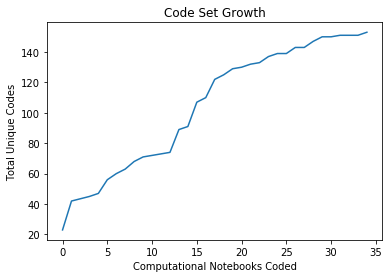

In [8]:
ax = sns.lineplot(x='coding order', y='cumulative count', markers=True, dashes=False, data=codesByArticle)
ax.set(xlabel='Computational Notebooks Coded', ylabel='Total Unique Codes', title='Code Set Growth')
plt.show()

Map codes back to the article where they were introduced to the code set.

In [9]:
for i, row in codesByArticle.iterrows():
    display(Markdown('{}. **{}**: {}'.format(i + 1, row.article, row['new codes'])))

1. **california-ccscore-analysis**: sort table, inner join tables, peek at data, export results, read as tabular data, split, compute, and merge, repetitive code, group by single column, plot histogram, inspect table schema, count number of records, calculate mean, count value frequency, remove incomplete data, format table display, drop columns, calculate z-score, adjust for season, calculate difference, drop entirely duplicate rows, calculate percentage difference, change column data type, filter rows

2. **2019-04-democratic-candidate-codonors**: use public data, prevent double-counting, union tables, create a semi-unique key, calculate scaled ratio, group by multiple columns, export intermediate results, calculate ratio, count unique values in column, change case, annotate workflow, gather table, architect a subroutine, sum column values, strip whitespace, self join table, outer join tables, canonicalize column names, remove with regular expression

3. **california-crop-production-wages-analysis**: adjust for inflation, architect repeating process, construct table manually

4. **census-hard-to-map-analysis**: slice column values, wrangle data for graphics

5. **long-term-care-db**: drop erroneous rows, scrape web for data, construct pivot table, perform name entity resolution manually, use non-public, provided data, join with lookup table, fix data errors manually, drop rows with duplicate value in one column, encode table identification in row

6. **2018-voter-registration**: plot stacked bar chart, extract single value, pull tables out of pdf, plot stacked column chart

7. **heat_and_humidity**: cartesian product, compute index number, generate data computationally

8. **2016-11-bellwether-counties**: use academic data, calculate spread, get max value, create rolling window, spread table

9. **2018-05-31-crime-and-heat-analysis**: plot scatterplot, combine seemingly disparate datasets, extract property from datetime

10. **2016-09-shy-trumpers**: use another news orgs data

11. **cube_root_law**: calculate using an external data structure

12. **2016-04-republican-donor-movements**: split column on delimiter

13. **california-h2a-visas-analysis**: cache results from external service, remove all rows but the master record, plot column chart, replace na values, omits data quality exploration, display entire table, encoding provenance in data, create a unique key, trim by geographic area, temporary joining column, trim by date range, create a crosstab, geocode addresses, split and compute, preserve existing values

14. **Endangered-Species-Act-Louisiana**: perform scalar multiplication, plot trendline

15. **Power_of_Irma**: value replacement, find most frequently occurring, use data from colleague, change date format, set data confidence threshold, toggle step on and off, tolerate dirty data, plot boxplot, find worst offender, log-ify values, look for trends, fit a generalized linear model, plot violin plot, use previously cleaned data, select columns, fix incorrect calculation

16. **wikipedia-rankings**: plot scree plot, collect raw data, analyze principle components

17. **babyname_politics**: break ties, join aggregate, assign ranks, trim by quantitative threshold, natural join, concatenate columns into key, resort after merge, round floating point, peel and merge, data loss from aggregation, check results of previous operation, get unique values

18. **2015-11-refugees-in-the-united-states**: compare total number of rows, designate column as primary key, make an incorrect conclusion

19. **employment-discrimination**: align table columns for consolidation, merge tables to create pivot table, concatenate files together, combine entities by string matching

20. **bechdel**: calculate median

21. **bob-ross**: run cluster analysis, whiten matrix

22. **nyc-trips**: full join tables

23. **work-from-home**: translate entity names manually, data too large for repo, create flag, test for equality

24. **buster-posey-mvp**: plot line chart, image analysis

25. **verge-uber-launch-dates**: 

26. **vox-central-line-infections**: report rows with column number discrepancies, sort table rows, remove delimiting characters, filter by contains value

27. **prison-admissions**: 

28. **school-star-ratings-2018**: reconcile primary keys between tables, display rows with errors, get min value, pad column values

29. **electric-car-charging-points**: add foreign key column, encode redundant information, define edge weights

30. **internal-migration-london**: 

31. **midwife-led-units**: test different computations for equality

32. **librarians**: 

33. **infrastructure-jobs**: 

34. **federal_employees_trump_2017**: create a table to lookup values, resolve to arbitrary entity name among choices

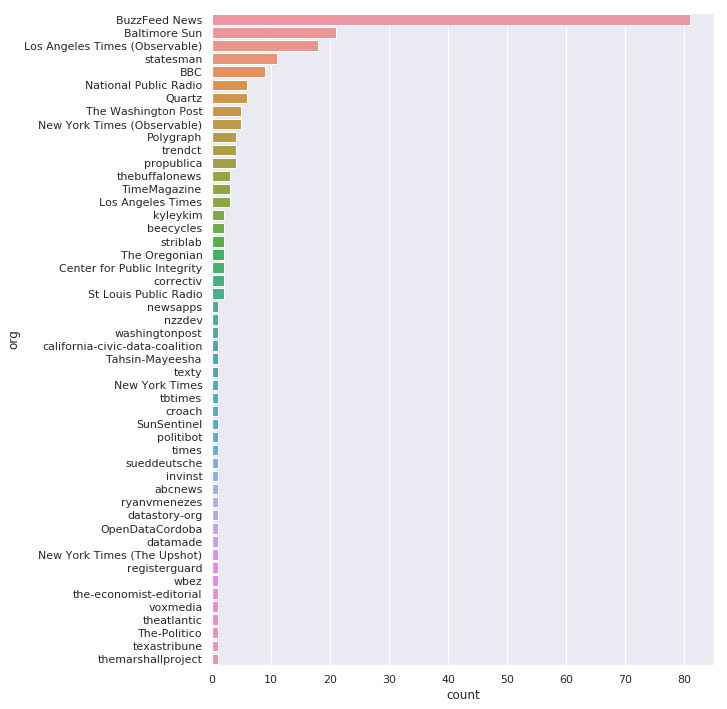

In [10]:
sns.set(rc={'figure.figsize': (9,12)})
sns.countplot(y='org', 
              data=keepers,
              order=keepers.org.value_counts().index)